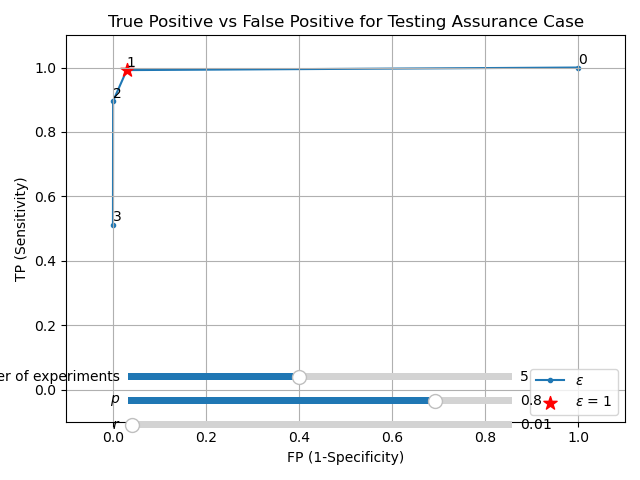

In [2]:
%matplotlib ipympl

import pybbn
import pandas as pd
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import networkx as nx
import matplotlib.pyplot as plt
import random
import sys
import os

from utils_sys import Printer

from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.sampling.sampling import LogicSampler

from scipy.stats import binom
import numpy as np
np.seterr(invalid='ignore')
import plotly
import plotly.io as pio
import chart_studio
import chart_studio.plotly as cspy
import chart_studio.tools as tls
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from urllib.request import urlopen
import json

import seaborn as sns

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

username = 'vishalgattani' # your username\n",
api_key = 'WSy2EFPTbxYYm3Rmcx53' # your api key - go to profile > settings > regenerate key\n",
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

def getBinomProb(total_exp_runs,p):
    return list(binom.pmf(list(range(total_exp_runs + 1)),total_exp_runs, p))

def evidence(join_tree,ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

def resetEvidence(join_tree):
    join_tree.unobserve_all()

def print_probs(join_tree):
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node.to_dict())
        print("Values:")
        print(potential)
        print('----------------')

    print("="*90)

def print_probs_node(join_tree,id):
    for node in join_tree.get_bbn_nodes():
        if (node.to_dict()['variable']['id']==id):
            potential = join_tree.get_bbn_potential(node)
            df = potential_to_df(join_tree.get_bbn_potential(node))
#             display(df)
            return df

def potential_to_df(p):
    data = []
    for pe in p.entries:
        try:
            v = pe.entries.values()[0]
        except:
            v = list(pe.entries.values())[0]
        p = pe.value
        t = (v, p)
        data.append(t)
    return pd.DataFrame(data, columns=['val', 'p'])

def potentials_to_dfs(join_tree):
    data = []
    for node in join_tree.get_bbn_nodes():
        name = node.variable.name
        df = potential_to_df(join_tree.get_bbn_potential(node))
        display(df)
        t = (name, df)
        data.append(t)
    return data

def drawBBN(bbn):
    n, d = bbn.to_nx_graph()
    pos = nx.spring_layout(n)
    nx.draw_spring(n, with_labels=True,labels=d)
    ax = plt.gca()

    plt.show()

def plotROC(p,r,fpr_tree, tpr_tree,fpr_lr, tpr_lr,fpr_lrl2, tpr_lrl2,fpr_nb, tpr_nb):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr_tree, y=tpr_tree, mode="markers+lines",name='DT'))
    fig.add_trace(go.Scatter(x=fpr_lr, y=tpr_lr, mode="markers+lines",name='LR'))
    fig.add_trace(go.Scatter(x=fpr_lrl2, y=tpr_lrl2, mode="markers+lines",name='LR(L2)'))
#     fig.add_trace(go.Scatter(x=fpr_nb, y=tpr_nb, mode="markers+lines",name='NB'))
    fig.update_layout(hovermode="x",title='Receiver Operating Characteristic '+"p="+str(p)+",r="+str(r))
    fig.update_xaxes(title_text='TPR')
    fig.update_yaxes(title_text='FPR')
    fig.show()

def getFPTN(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'False', 1.0)
    df = print_probs_node(join_tree,0)
    resetEvidence(join_tree)
    dffp = df[df['val']=='Correct']['p']
    dftn = df[df['val']=='Incorrect']['p']
    return dffp,dftn

def getFNTP(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
    df = print_probs_node(join_tree,0)
    resetEvidence(join_tree)
    dffn = df[df['val']=='Incorrect']['p']
    dftp = df[df['val']=='Correct']['p']
    return dffn,dftp

path = "mytest"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

from matplotlib.widgets import Slider

def testingAC(n,p,r):

    # threshold_num_runs = 2 # rule
    min_exp_runs = n
    max_exp_runs = n

    total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))


    row = []

    p = p
    r = r


    for total_exp_runs in total_exp_runs_list:
        for threshold_num_runs in range(0,n+1):
                # for p in p_list:
                # for r in r_list:
    #                 print("p(successful run|algo = T):",p)
    #                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                    exp_T = getBinomProb(total_exp_runs,p)
                    exp_F = getBinomProb(total_exp_runs,r)
                    exp_dict = {"True":exp_T,"False":exp_F}
                    exp_cpt = pd.DataFrame(exp_dict)
                    test_keys = []
                    test_values = []

                    for i in range(total_exp_runs+1):
                        test_keys.append(str(i))
                        if i >= threshold_num_runs:
                            test_values.append([1,0])
                        else:
                            test_values.append([0,1])

                    test_results_dict = dict(zip(test_keys, test_values))
                    test_results_cpt = pd.DataFrame(test_results_dict)
                    test_results_cpt["States"] = ['Correct','Incorrect']
                    test_results_cpt.set_index("States",inplace=True)

                    # display(test_results_cpt)


                    # Create nodes by manually typing in probabilities
                    test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                    exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                    algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                    bbn = Bbn() \
                        .add_node(algo) \
                        .add_node(exp1) \
                        .add_node(test_results) \
                        .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                        .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                    join_tree = InferenceController.apply(bbn)

                    dffp,dftn = getFPTN(join_tree)
                    dffn,dftp = getFNTP(join_tree)

    #                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
    #                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
    #                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
    #                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                    fp = dffp.tolist()[0]
                    tn = dftn.tolist()[0]
                    fn = dffn.tolist()[0]
                    tp = dftp.tolist()[0]

                    data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                    row.append(data)
    #                 print("+"*80)

        checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
    #     display(checkdf)

    df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
    # display(df.head())

    dfs = df.groupby(['n_exp','p','r'])
    fig = go.Figure()
    best_dfs = []
    subplots_df = []
    for i in dfs:
        fpr = i[1].fp.to_numpy()
        tpr = i[1].tp.to_numpy()
        distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
        i[1]["distances"] = distances
        # find index of the point with minimum distance
        min_index = np.argmin(distances)
        # get the corresponding values of FP and TP
        best_fp = fpr[min_index]
        best_tp = tpr[min_index]
        # find the row with the least value in the 'Salary' column
        best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
        best['n_exp'] = best['n_exp'].astype(int)
        best['threshold_exp'] = best['threshold_exp'].astype(int)
        best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]

        p = i[1].p.unique().tolist()[0]
        r = i[1].r.unique().tolist()[0]
        subplots_df.append(i[1])
        # Create a scatter plot with red "*" markers
        # plt.scatter(best.FP, best.TP, s=100, marker="*", color="red",zorder=1)
        bestpt = best["Threshold number of successes"].values.tolist()[0]

    # result = pd.concat(best_dfs, axis=0, ignore_index=True)
    # # drop a column
    # result = result.drop('distances', axis=1)
    # result = result.round({'TP':4,'TN':4,'FP':4,'FN':4})
    # # convert the 'float_col' column to integer

    # # display(result)
    # rvals = '-'.join(str(e) for e in result.r.unique().tolist())
    # pvals = '-'.join(str(e) for e in result.p.unique().tolist())
    # fname = '-'.join(['p',pvals,'r',rvals])+".csv"
    df.columns = ['n','e','p','r','fp','tn','fn','tp']
    return df,best,bestpt


fig, ax = plt.subplots()

df,best,bestpt = testingAC(3,0.8,0.01)
ax.plot(df.fp,df.tp,marker=".",zorder = -1)
ax.scatter(best.FP, best.TP, s=100, marker="*", color="red",zorder=1)

# ax.annotate(str(best["Threshold number of successes"].tolist()[0]), ((best.iloc[0].FP), (best.iloc[0].TP)+0.01))
for j in range(len(df)):
#         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
    ax.annotate(str(df.e.tolist()[j]), ((df.iloc[j].fp), (df.iloc[j].tp)+0.01))
plt.legend(["$\epsilon$","$\epsilon$ = "+str(bestpt)]  ,loc='lower right')

# fig, ax = plt.subplots()
plt.xlabel(f"FP (1-Specificity)")
plt.ylabel('TP (Sensitivity)')
plt.title(f'True Positive vs False Positive for Testing Assurance Case')
# plt.ticks(x_pos + bar_width / 2)
# plt.xticks(ticks=x_pos + bar_width / 2,labels=x_labels)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(True)

# # Add legend
# plt.legend(loc = "upper right")
plt.tight_layout()



# Create the sliders
slider_ax1 = plt.axes([0.2, 0.20, 0.6, 0.03])
slider1 = Slider(slider_ax1, 'Number of experiments', 1, 10, valinit=5, valstep=1, valfmt='%0.0f')

slider_ax3 = plt.axes([0.2, 0.15, 0.6, 0.03])
slider3 = Slider(slider_ax3, '$p$', 0, 1, valinit=0.8)

slider_ax4 = plt.axes([0.2, 0.10, 0.6, 0.03])
slider4 = Slider(slider_ax4, '$r$', 0, 1, valinit=0.01)

case3 = False
if case3:
    slider_ax5 = plt.axes([0.2, 0.05, 0.6, 0.03])
    slider5 = Slider(slider_ax5, '$k$', 0, 1, valinit=0.0)

# Define the update function
def update(val):
    n = slider1.val
    if case3:
        k = slider5.val
    p1 = slider3.val
    # Printer.orange(k)
    if case3:
        if(np.round(k,3)==0.000 or k==0):
            p2 = slider4.val
        else:
            p2 = k * p1 #slider4.val
            # slider4.val = p2
            slider_ax4.clear() #Clear the axis
            slider4.__init__(slider_ax4, '$r$', 0, 1, valinit=p2)
    # else:
    p2 = slider4.val
    df,best,bestpt = testingAC(n,p1,p2)
    # ax.plot(df.fp,df.tp,marker=".",zorder = -1)
    # ax.scatter(best.FP, best.TP, s=100, marker="*", color="red",zorder=1)

    ax.cla()
    ax.set_xlabel(f"FP (1-Specificity)")
    ax.set_ylabel('TP (Sensitivity)')
    ax.set_title(f'True Positive vs False Positive for Testing Assurance Case')
    ax.plot(df.fp,df.tp,marker=".",zorder = -1)
    ax.scatter(best.FP, best.TP, s=100, marker="*", color="red",zorder=1)
    ax.legend(["$\epsilon$","$\epsilon$ = "+str(bestpt)]  ,loc='lower right')
    for j in range(len(df)):
#         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
        ax.annotate(str(df.e.tolist()[j]), ((df.iloc[j].fp), (df.iloc[j].tp)+0.01))


    # ax.annotate(str(best["Threshold number of successes"].tolist()[0]), ((best.iloc[0].FP), (best.iloc[0].TP)+0.01))

    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(-0.1,1.1)
    ax.grid(True)

    # ax.set_title(f'Probabilities of Top Claim\nvs\n threshold $\epsilon$ = {nt}')
    # ax.set_xlabel(f"$n={n},nt={nt},p_1={p1:.2f},p_2={p2:.2f},p_t={pt:.2f}$")
    fig.canvas.draw_idle()
    # plt.canvas.draw_idle()

slider1.on_changed(update)
slider3.on_changed(update)
slider4.on_changed(update)
if case3:
    slider5.on_changed(update)

plt.show()